In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dataset is already splitted in train, validation, test
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}

# read train split
df_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [2]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


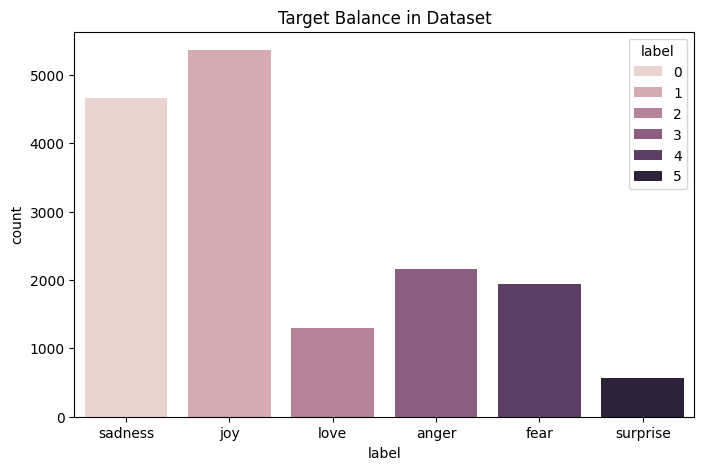

In [3]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_train, x="label", hue="label")
plt.title("Target Balance in Dataset")
ax.set_xticks([0, 1, 2, 3, 4, 5]) 
ax.set_xticklabels(["sadness", "joy", "love", "anger", "fear", "surprise"])
plt.show()

In [4]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
df_train["text_len"] = [len(text.split()) for text in df_train["text"].values]
df_train.head()

,text,label,text_len
0,i didnt feel humiliated,0,4
1,i can go from feeling so hopeless to so damned...,0,21
2,im grabbing a minute to post i feel greedy wrong,3,10
3,i am ever feeling nostalgic about the fireplac...,2,18
4,i am feeling grouchy,3,4


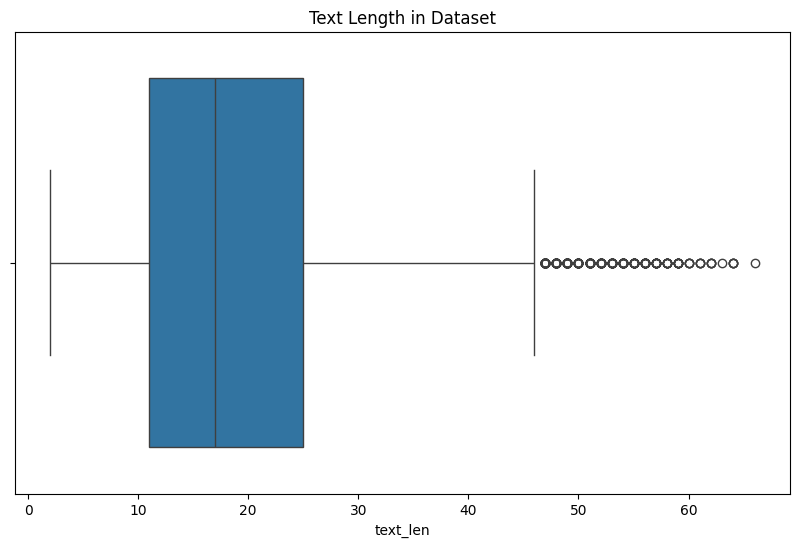

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="text_len", data=df_train)
plt.title("Text Length in Dataset")
plt.show()

In [7]:
df_train = df_train.drop("text_len", axis=1)
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
# Shuffle Datasets

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_validation = df_validation.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
import os 

parquet_save_path = "dataset_parquets/"

if not os.path.exists(parquet_save_path):
    os.makedirs(parquet_save_path)
    df_train.to_parquet(os.path.join(parquet_save_path, "emotion_train.parquet"))
    df_validation.to_parquet(os.path.join(parquet_save_path, "emotion_validation.parquet"))
    df_test.to_parquet(os.path.join(parquet_save_path, "emotion_test.parquet"))

In [10]:
# Create Smaller Train For Testing to see if all works fine

df_train_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_train.parquet"))[:1000]
len(df_train_small)

1000

In [11]:
# Create Smaller Validation for Testing to see if all works fine

df_validation_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_validation.parquet"))[:250]
len(df_validation_small)

250

In [12]:
df_test_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_test.parquet"))[:250]
len(df_test_small)

250

In [13]:
from datasets import Dataset, DatasetDict

# create transformers Dataset from parquet files
train_dataset = Dataset.from_pandas(df_train_small)
validation_dataset = Dataset.from_pandas(df_validation_small)
test_dataset = Dataset.from_pandas(df_test_small)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [14]:
from transformers import AutoTokenizer

# load tokenizer and preprocess dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True)


tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [15]:
from transformers import TFAutoModelForSequenceClassification

num_labels = 6
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
label2id = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

# load Distilbert Model in Tensorflow Format
model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert/distilbert-base-uncased",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

2024-10-29 13:12:31.132970: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 13:12:31.372587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730203951.471154   10365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730203951.501987   10365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 13:12:31.744894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [16]:
from transformers import DataCollatorWithPadding

# for padding strategy
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [17]:
# Prepare Dataset for Tensorflow

tf_train_set = model.prepare_tf_dataset(
        tokenized_dataset["train"],
        shuffle=True,
        batch_size=32,
        collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
        tokenized_dataset["validation"],
        shuffle=False,
        batch_size=32,
        collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
        tokenized_dataset["test"],
        shuffle=False,
        batch_size=32,
        collate_fn=data_collator,
)

In [20]:
from tf_keras.optimizers import Adam 

optimizer = Adam(learning_rate=2e-5)

# compile Model with Optimizer
model.compile(optimizer=optimizer)

In [21]:
import evaluate 
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Berechne jede Metrik separat
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")

    # Kombiniere die Ergebnisse
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
    }

In [22]:
from transformers.keras_callbacks import KerasMetricCallback 
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(patience=8, monitor="val_loss", restore_best_weights=True)

reduce_lr_on_plateau = ReduceLROnPlateau(patience=4, monitor="val_loss", verbose=1)

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_set
)

In [23]:
history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=15,
    callbacks=[metric_callback ,early_stopping, reduce_lr_on_plateau],
)

Epoch 1/15


I0000 00:00:1730204044.691649   10709 service.cc:148] XLA service 0x767674895a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730204044.691758   10709 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-10-29 13:14:04.702799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730204044.723312   10709 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730204044.864671   10709 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 18s 210ms/step - loss: 1.6465 - val_loss: 1.5630 - accuracy: 0.3520 - f1: 0.2242 - lr: 2.0000e-05


2024-10-29 13:14:14.653038: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/15
31/31 [==============================] - 3s 93ms/step - loss: 1.4205 - val_loss: 1.2310 - accuracy: 0.5720 - f1: 0.4412 - lr: 2.0000e-05
Epoch 3/15
 1/31 [..............................] - ETA: 2s - loss: 0.9687

2024-10-29 13:14:17.656449: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 3s 81ms/step - loss: 1.0803 - val_loss: 0.9907 - accuracy: 0.6720 - f1: 0.6024 - lr: 2.0000e-05
Epoch 4/15
31/31 [==============================] - 2s 77ms/step - loss: 0.7839 - val_loss: 0.7200 - accuracy: 0.7760 - f1: 0.7383 - lr: 2.0000e-05
Epoch 5/15
 1/31 [..............................] - ETA: 1s - loss: 0.6089

2024-10-29 13:14:22.659616: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 2s 78ms/step - loss: 0.4956 - val_loss: 0.5529 - accuracy: 0.8360 - f1: 0.8215 - lr: 2.0000e-05
Epoch 6/15
31/31 [==============================] - 2s 74ms/step - loss: 0.2970 - val_loss: 0.4374 - accuracy: 0.8640 - f1: 0.8583 - lr: 2.0000e-05
Epoch 7/15
31/31 [==============================] - 2s 68ms/step - loss: 0.1780 - val_loss: 0.4192 - accuracy: 0.8800 - f1: 0.8761 - lr: 2.0000e-05
Epoch 8/15
31/31 [==============================] - 2s 64ms/step - loss: 0.1037 - val_loss: 0.4318 - accuracy: 0.8800 - f1: 0.8765 - lr: 2.0000e-05
Epoch 9/15
 1/31 [..............................] - ETA: 2s - loss: 0.0577

2024-10-29 13:14:31.484035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 2s 67ms/step - loss: 0.0755 - val_loss: 0.4155 - accuracy: 0.8760 - f1: 0.8725 - lr: 2.0000e-05
Epoch 10/15
31/31 [==============================] - 2s 66ms/step - loss: 0.0513 - val_loss: 0.4247 - accuracy: 0.8760 - f1: 0.8738 - lr: 2.0000e-05
Epoch 11/15
31/31 [==============================] - 2s 63ms/step - loss: 0.0382 - val_loss: 0.4537 - accuracy: 0.8760 - f1: 0.8753 - lr: 2.0000e-05
Epoch 12/15
31/31 [==============================] - 2s 66ms/step - loss: 0.0300 - val_loss: 0.4935 - accuracy: 0.8760 - f1: 0.8730 - lr: 2.0000e-05
Epoch 13/15
31/31 [==============================] - ETA: 0s - loss: 0.0268
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999949504854e-06.
31/31 [==============================] - 2s 63ms/step - loss: 0.0268 - val_loss: 0.4575 - accuracy: 0.8680 - f1: 0.8685 - lr: 2.0000e-05
Epoch 14/15
31/31 [==============================] - 2s 64ms/step - loss: 0.0247 - val_loss: 0.4640 - accuracy: 0.8680 - f1: 

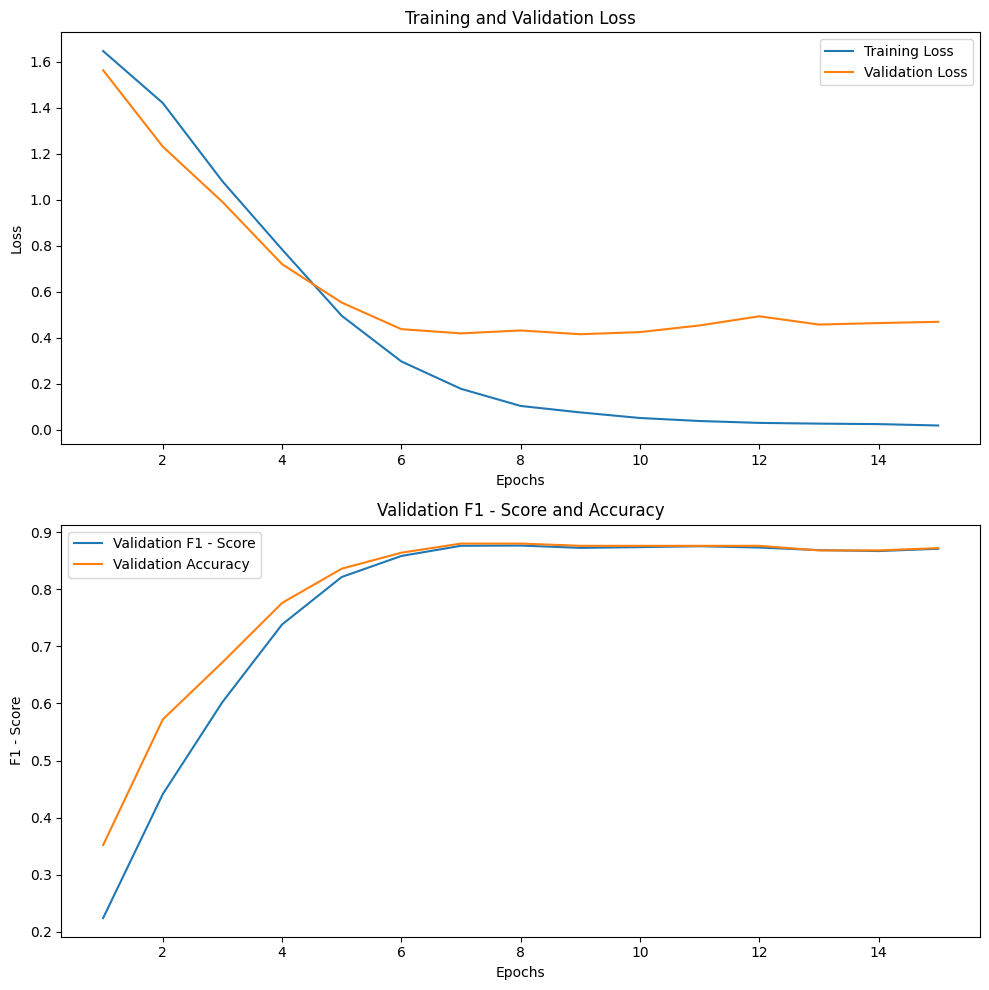

In [24]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

val_accuracy = history.history["accuracy"]
val_f1 = history.history["f1"]

epochs = range(1, len(history.history["loss"]) + 1)  # Start epochs at 1

# Plotting setup for a vertical layout
plt.figure(figsize=(10, 10))  # Use provided figure size

# Plot loss
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot = loss
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot = f1-score
plt.plot(epochs, val_f1, label="Validation F1 - Score")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Validation F1 - Score and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("F1 - Score")
plt.legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [62]:
import tensorflow as tf

# testing model

text = "i feel so tired"
correct_label = 0 # sadness 

inputs = tokenizer(text, return_tensors="tf")
logits = model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'sadness'

In [48]:
import tensorflow as tf

# Get predicted labels
y_pred_logits = model.predict(tf_test_set).logits
y_pred = tf.math.argmax(y_pred_logits, axis=-1).numpy()  # Convert to numpy array

y_true = df_test_small["label"].values
X_test = df_test_small["text"].values

8/8 [==============================] - 0s 19ms/step


In [49]:
test_acc = accuracy.compute(predictions=y_pred, references=y_true)

# Print accuracy
print("Test Accuracy:", test_acc)

Test Accuracy: {'accuracy': 0.876}


In [54]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)


def classification_evaluation_pipeline(
    X_test: pd.Series,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    classes: list,
    metrics_average: str = "weighted",
    save_folder: str = "save_folder",
) -> None:
    """
    Evaluates the classification model by generating a comprehensive report including classification
    metrics and a confusion matrix. Optionally, it can also return a DataFrame containing incorrect predictions if specified.

    Args:
        X_test (pd.Series): The input text data used for testing the model.
        y_true (np.ndarray): True labels of the test data.
        y_pred (np.ndarray): Predicted labels as returned by the classifier.
        classes (list): List of class names for more interpretable visualizations.
        get_wrong_preds (bool, optional): Flag to determine if the function should return a DataFrame with wrong predictions. Defaults to False.

    Returns:
        None or (pd.DataFrame, pd.DataFrame): If get_wrong_preds is True, returns a tuple of two DataFrames:
            1. DataFrame of the test data, predictions, and true labels.
            2. DataFrame of incorrect predictions only.

    Example usage:
        y_pred = model.predict(X_test)
        classes = ["Class 0", "Class 1"]
        metrics_average = "weighted"
        save_folder = "model_1"
        classification_evaluation_pipeline(X_test=X_test, y_true=y_test, y_pred=y_pred, classes=classes, metrics_average=metrics_average, save_folder=save_folder)
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    print("Printing Classification Report")
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=classes))
    print("Plotting Classification Report with Support")
    report = classification_report(
        y_pred=y_pred, y_true=y_true, output_dict=True, target_names=classes
    )
    plot_classification_report_with_support(report=report, save_folder=save_folder)
    report_df = pd.DataFrame(report)
    report_df.to_csv(f"{save_folder}/classification_report.csv", index=False)

    print("Plot Confusion Matrix")
    make_confusion_matrix(
        y_true=y_true, y_pred=y_pred, classes=classes, save_folder=save_folder
    )

    print("Getting wrong Predictions.")
    df_predictions, wrong_preds = get_wrong_predictions(
        X_test=X_test,
        y_pred=y_pred,
        y_true=y_true,
        classes=classes,
    )
    df_predictions.to_csv(f"{save_folder}/all_model_predictions.csv", index=False)
    wrong_preds.to_csv(f"{save_folder}/model_wrong_predictions.csv", index=False)

    print("Calculating Accuracy, F1-Score, Precision and Recall")
    df_metrics = calculate_metrics(
        y_pred=y_pred, y_true=y_true, average=metrics_average
    )
    df_metrics.to_csv(f"{save_folder}/model_metrics_{metrics_average}.csv", index=False)


def plot_classification_report_with_support(report: dict, save_folder: str):
    labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    metrics = ["precision", "recall", "f1-score", "support"]
    data = np.array([[report[label][metric] for metric in metrics] for label in labels])
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.matshow(data, cmap="coolwarm")
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    # Adding the text
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="white")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.title("Classification Report with Support")
    plt.savefig(f"{save_folder}/classification_report.png")
    plt.show()


def make_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    save_folder: str,
    classes: np.ndarray = None,
    figsize: tuple[int, int] = (10, 10),
    text_size: int = 15,
    cmap: str = "Blues",
    norm: bool = False,
) -> None:
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels, with options to normalize
    and save the figure.

    Args:
      y_true (np.ndarray): Array of truth labels (must be same shape as y_pred).
      y_pred (np.ndarray): Array of predicted labels (must be same shape as y_true).
      classes (np.ndarray): Array of class labels (e.g., string form). If `None`, integer labels are used.
      figsize (tuple[int, int]): Size of output figure (default=(10, 10)).
      text_size (int): Size of output figure text (default=15).
      norm (bool): If True, normalize the values in the confusion matrix (default=False).
      savefig (bool): If True, save the confusion matrix plot to the current working directory (default=False).

    Returns:
        None: This function does not return a value but displays a Confusion Matrix. Optionally, it saves the plot.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10,
                            norm=True,
                            savefig=True)
    """
    # Create the confusion matrix
    cm = (
        confusion_matrix(y_true, y_pred, normalize="true")
        if norm
        else confusion_matrix(y_true, y_pred)
    )

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    # Set class labels
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(len(cm))

    # Set the labels and titles
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
    )
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Annotate the cells with the appropriate values
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i, j]:.2f}" if norm else f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
            size=text_size,
        )

    plt.tight_layout()
    # Save the figure if requested
    plt.savefig(f"{save_folder}/confusion_matrix.png")
    plt.show()


def get_wrong_predictions(
    X_test: pd.Series,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    classes: list,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Identifies and returns the correct and incorrect predictions made by a classification model.
    The function creates a DataFrame that includes the test inputs, actual and predicted labels, and class names.
    It also visualizes the distribution of correct and incorrect predictions.

    Args:
        X_test (pd.Series): The input text data that was used for testing the model, used here to trace back incorrect predictions to the original inputs.
        y_true (np.ndarray): The actual labels from the test data, representing the true classes of the inputs.
        y_pred (np.ndarray): The predicted labels produced by the classification model, used to compare against the true labels to determine prediction correctness.
        classes (list): A list of class names corresponding to the label indices, used to convert label indices into human-readable class names for easier interpretation and visualization.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames:
            1. The first DataFrame includes all predictions with columns for the text, actual and predicted labels, and whether each prediction was correct.
            2. The second DataFrame is a subset of the first and includes only the rows where the predictions were incorrect.

    The function also plots a count plot showing the balance between correct and incorrect predictions across predicted class labels.
    """
    df_dict = {
        "text": X_test,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_true_classnames": [classes[i] for i in y_true],
        "y_pred_classnames": [classes[i] for i in y_pred],
    }

    df_pred = pd.DataFrame(df_dict).reset_index(drop=True)
    df_pred["pred_correct"] = df_pred["y_true"] == df_pred["y_pred"]

    plt.figure(figsize=(8, 4))
    sns.countplot(x="pred_correct", hue="y_pred_classnames", data=df_pred)
    plt.title("Balance between Predictions")
    plt.show()

    wrong_preds = df_pred[df_pred["pred_correct"] == False].reset_index(drop=True)
    return df_pred, wrong_preds


def calculate_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, average: str = "weighted"
):
    acc_score = accuracy_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true, average=average)
    precision = precision_score(y_pred=y_pred, y_true=y_true, average=average)
    recall = recall_score(y_pred=y_pred, y_true=y_true, average=average)

    df_dict = {
        f"accuracy": acc_score,
        f"f1-score_{average}": f1,
        f"precision_{average}": precision,
        f"recall_{average}": recall,
    }

    df_metrics = pd.DataFrame([df_dict])
    return df_metrics

Printing Classification Report
              precision    recall  f1-score   support

     sadness       0.91      0.90      0.91        81
         joy       0.95      0.91      0.93        89
        love       0.70      0.70      0.70        23
       anger       0.74      0.85      0.79        27
        fear       0.79      0.86      0.83        22
    surprise       1.00      0.88      0.93         8

    accuracy                           0.88       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.88      0.88      0.88       250

Plotting Classification Report with Support


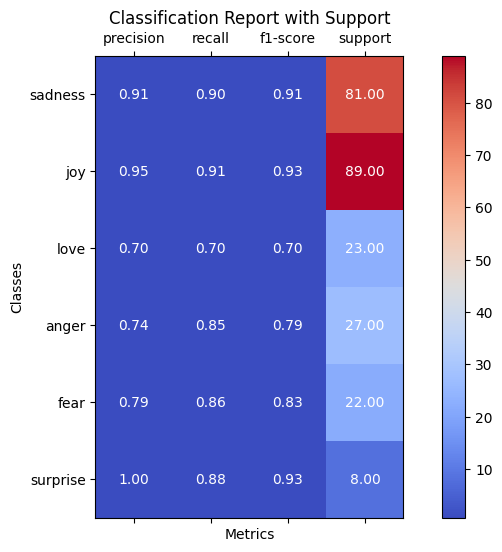

Plot Confusion Matrix


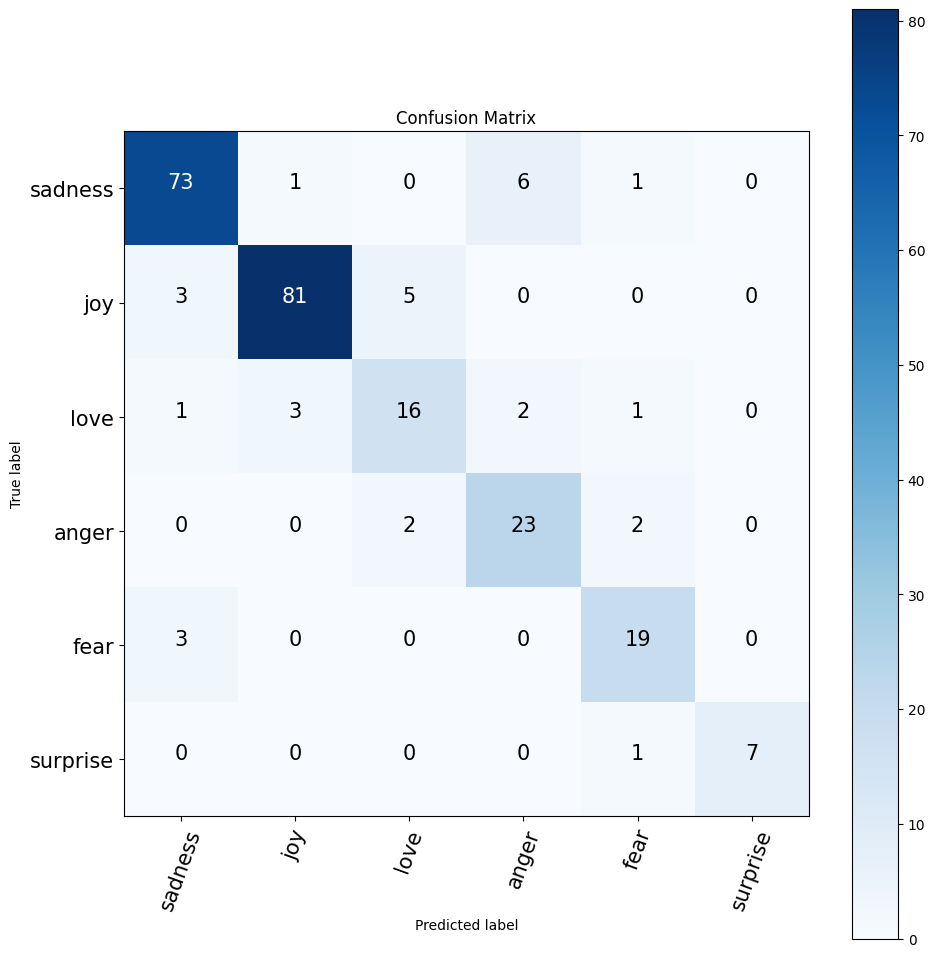

Getting wrong Predictions.


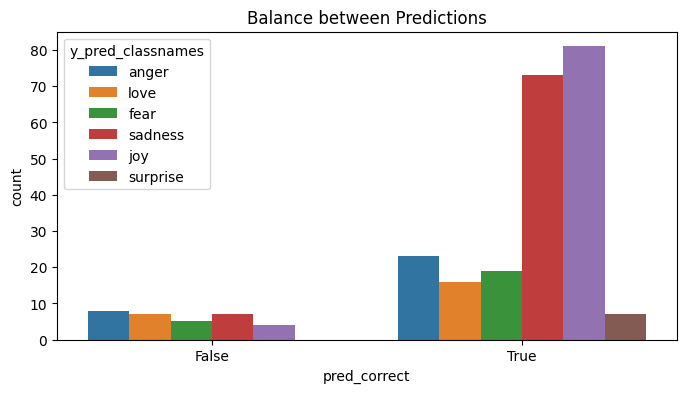

Calculating Accuracy, F1-Score, Precision and Recall


In [55]:
save_folder = "distilbert_evaluation/"
classes = ["sadness", "joy", "love", "anger", "fear", "surprise"]

classification_evaluation_pipeline(save_folder=save_folder, X_test=X_test, y_pred=y_pred, y_true=y_true, classes=classes)

In [56]:
# get wrong predictions csv from evaluation

evaluation_folder = "distilbert_evaluation"
wrong_predictions_csv = os.path.join(evaluation_folder, "model_wrong_predictions.csv")

wrong_predictions_df = pd.read_csv(wrong_predictions_csv)
wrong_predictions_df.head()

,text,y_true,y_pred,y_true_classnames,y_pred_classnames,pred_correct
0,i feel so dirty but after spending a day at th...,0,3,sadness,anger,False
1,i could feel his breath on me and smell the sw...,1,2,joy,love,False
2,i have felt the need to write out my sometimes...,3,4,anger,fear,False
3,at a party i met a girl who drew me to her,3,2,anger,love,False
4,i feel this strange sort of liberation,5,4,surprise,fear,False
